## Example of cdr3-QTL analysis
- HLA-DRB1 site 13
- L13-CDR3 position 109

In [1]:
library(magrittr)
library(data.table)
library(plyr)
library(ggsci)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(ggseqlogo)

## 1, Read in data
- genotype of DRB1_pos13
- amino acid frequencies at position 109 of CDR3 (L=13)
- covariates of PC1-3

In [2]:
load("DRB1_site13_L13CDR3_p109.RData")
pdata <- out[[1]] #CDR3 phenotype
gdata <- out[[2]] #genotype at HLA-DRB1
cdata <- out[[3]] #covariates

#### 1-1, CDR3 phenotype

In [38]:
head(pdata,n=2) #sample name, amino acid ID, usage ratio

Sample,AA,rate
HIP00110,A,0.066906200
HIP00110,C,0.000359324


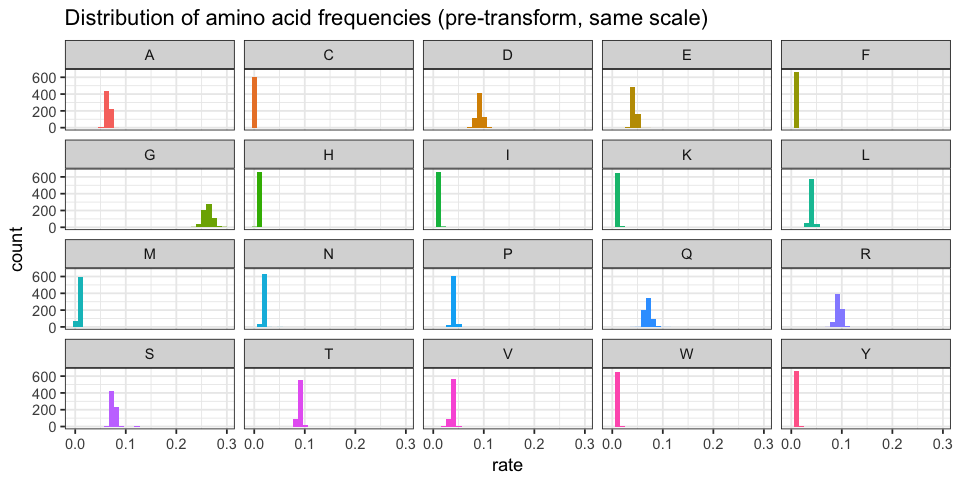

In [40]:
#distributions, raw data
#absolute value varies a lot
df <- pdata

options(repr.plot.width=8, repr.plot.height=4)
df %>% ggplot(aes(x=rate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA)+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

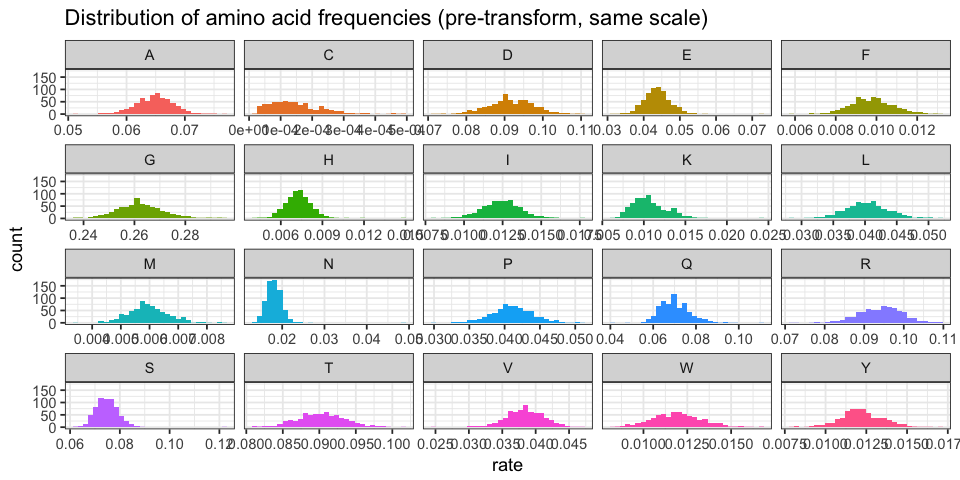

In [42]:
#look at the same data with the free scale in the X axis
df %>% ggplot(aes(x=rate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA,scale="free_x")+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

In [45]:
#transform each amino acid frequency into a standard normal distribution (INT-transform)
pall <- data.frame()
pnamelist <- unique(pdata$AA)
for( ptarget in pnamelist ){
    pdata2 <- subset(pdata, AA==ptarget)
    pdata2 <- pdata2[,c("Sample", "rate")]
    x <- pdata2$rate
    pdata2$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
    
    df <- pdata2[,c("Sample","normrate")]
    df$AA <- ptarget
    pall <- rbind(pall,df)
}
head(pall,n=2)

,Sample,normrate,AA
1,HIP00110,0.67922234,A
21,HIP00169,-0.06968492,A


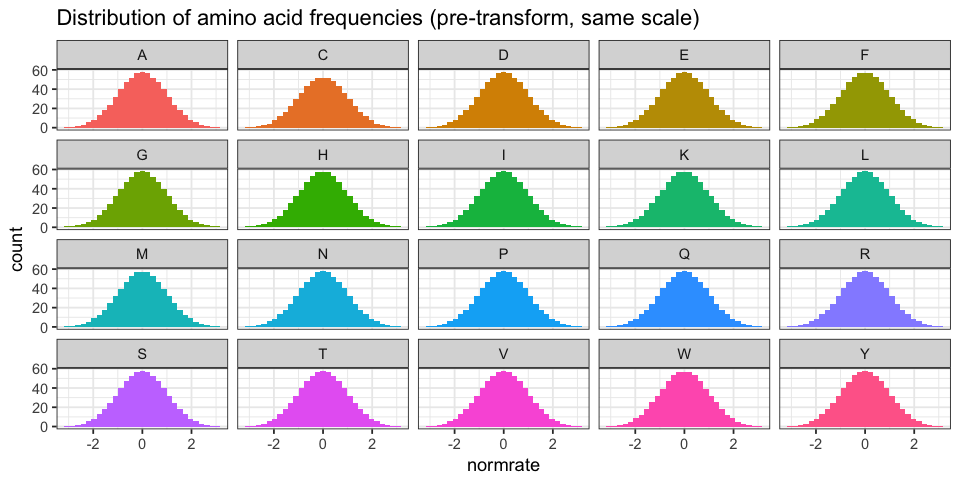

In [46]:
options(repr.plot.width=8, repr.plot.height=4)
df <- pall
df %>% ggplot(aes(x=normrate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA)+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

In [49]:
#transform pall into a matrix
mat <- matrix(0, nrow=length(unique(pall$Sample)), ncol=length(unique(pall$AA)) )
row.names(mat) <- unique(pall$Sample)
colnames(mat) <- unique(pall$AA)

for( i in unique(pall$Sample) ){
for( k in unique(pall$AA) ){
   out <- subset(pall, Sample==i & AA==k)
   if( nrow(out) ==1 ){
      mat[i,k] <- out$normrate
   }else{
       mat[i,k] <- 0
   }
}
}
mat <- data.frame(Sample=row.names(mat),mat)
head(mat,n=2)

,Sample,A,C,D,E,F,G,H,I,K,⋯,M,N,P,Q,R,S,T,V,W,Y
HIP00110,HIP00110,0.67922234,1.9515905,-1.1412792,-1.938580,-0.1475388,1.308539,-1.307693,-1.078567,1.140362,⋯,0.2203945,-0.9175417,-0.2374441,-1.1558372,1.5116197,0.07723269,-0.02446653,1.240705,1.626895,0.2959513
HIP00169,HIP00169,-0.06968492,-0.6822739,0.2763461,-2.079869,1.5472436,-1.201055,1.752434,3.174393,1.223734,⋯,1.4763512,1.2166860,-1.3732660,-0.8671024,0.9584461,-0.27634606,0.13781024,3.174393,-1.264599,-1.4550853


#### 1-2, HLA-DRB1 site 13 allele count

In [50]:
colnames(gdata) <- c('Sample',
                     'F_allele','G_allele','H_allele','R_allele','S_allele','Y_allele')
head(gdata,n=2)
rowSums(gdata[,-1]) %>% table() #all, sum = 2 (because each individual has two alleles)

#allele frequency
gdata[,-1] %>% colSums()/nrow(gdata)/2
    #S_allele is the most frequent allele

,Sample,F_allele,G_allele,H_allele,R_allele,S_allele,Y_allele
HIP00110,HIP00110,0,0,0,2,0,0
HIP00169,HIP00169,0,0,0,2,0,0


.
  2 
630 

F_allele   G_allele   H_allele   R_allele   S_allele   Y_allele 
0.13968254 0.05634921 0.16031746 0.15555556 0.36269841 0.12539683

#### 1-3, covariate (genotype PCA)

In [51]:
head(cdata,n=2)

,Sample,PC1,PC2,PC3
HIP00110,HIP00110,-0.3715639,0.1614687,0.9765430
HIP00169,HIP00169,-0.8574693,1.4323182,-0.9377073


## 2, Estimate P value using R function anova.mlm
- This is the way I calculate P value in my manuscript (Pillai statistics in MANOVA)

In [53]:
M <- merge(gdata,mat,by="Sample")
M <- merge(M,cdata,by="Sample")
head(M,n=2)

Sample,F_allele,G_allele,H_allele,R_allele,S_allele,Y_allele,A,C,D,⋯,Q,R,S,T,V,W,Y,PC1,PC2,PC3
HIP00110,0,0,0,2,0,0,0.67922234,1.9515905,-1.1412792,⋯,-1.1558372,1.5116197,0.07723269,-0.02446653,1.240705,1.626895,0.2959513,-0.3715639,0.1614687,0.9765430
HIP00169,0,0,0,2,0,0,-0.06968492,-0.6822739,0.2763461,⋯,-0.8671024,0.9584461,-0.27634606,0.13781024,3.174393,-1.264599,-1.4550853,-0.8574693,1.4323182,-0.9377073


In [54]:
#full model (exclude S_allele, the most frequent allele, as the reference allele)
mod1 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

#null model
mod0 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

In [57]:
test <- anova(mod1, mod0)
test
    #P manova = 2.660403e-138

Res.Df,Df,Gen.var.,Pillai,approx F,num Df,den Df,Pr(>F)
619,NA,0.5945617,NA,NA,NA,NA,NA
624,5,0.6416781,1.329817,10.94236,100,3020,2.660403e-138


## 3, Estimate P value using custom script
- Successfully reproduced the same statistics as in STEP2.
- https://online.stat.psu.edu/stat505/lesson/8
- https://support.sas.com/documentation/cdl/en/statug/63033/

In [ ]:
#full model (exclude S_allele, the most frequent allele, as the reference allele)
mod1 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

#null model
mod0 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

In [58]:
#response variable matrix
Y <- M[,c("A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y")]
Y <- as.matrix(Y)
dim(Y)
Y[1:5,1:5]

[1] 628  20

A,C,D,E,F
0.67922234,1.9515905,-1.1412792,-1.9385796,-0.1475388
-0.06968492,-0.6822739,0.2763461,-2.0798691,1.5472436
0.37157379,1.4406943,-1.1059024,-0.5474289,0.6313380
0.54306204,-1.5143614,0.2258458,-0.1530252,-0.1323129
2.84048462,1.0556713,-2.6734518,-1.1781452,-1.0062700


In [68]:
#degree of freedom of full and null model
DF_full <- mod1$df.residual
DF_null <- mod0$df.residual

DF_full
DF_null

[1] 619

[1] 624

In [62]:
#matrix of residuals
Res_full <- Y - mod1$fitted.values
dim(Res_full)

[1] 628  20

In [63]:
Res_null <- Y - mod0$fitted.values
dim(Res_null)

[1] 628  20

In [66]:
Emat <- crossprod(Res_full)
Hmat <- crossprod(Res_null) - crossprod(Res_full)
dim(Emat)
dim(Hmat)

[1] 20 20

[1] 20 20

In [67]:
Pillai <- sum(diag( Hmat %*% solve( Hmat + Emat ) ))
Pillai

[1] 1.329817

In [69]:
p=20 #DF of Y matrix (N of amino acids)
q=5 #DF of X (dose1-dose5)
s=min(p,q)
v=DF_full
m=(abs(p-q)-1)/2
n=(v-p-1)/2
appF <- (2*n + s + 1)/(2*m + s + 1) * ( Pillai / (s - Pillai) )
appF #the identical value as R function (see above)

[1] 10.94236

In [70]:
numDF <- s*(2*n + s + 1)
numDF #the identical value as R function (see above)

[1] 3020

In [71]:
dnomDF <- s*(2*m + s + 1)
dnomDF #the identical value as R function (see above)

[1] 100

In [72]:
pf(appF, dnomDF,numDF, lower.tail = FALSE) #the identical value as R function (see above)

[1] 2.660403e-138

## 4, Variance explained using R function MVLM

In [74]:
library(MVLM)

#full model
mod1 <- mvlm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

var_exp_full <- mod1$pseudo.rsq["Omnibus Effect",1]
show(var_exp_full)

Omnibus Effect 
     0.1312758 


In [75]:
#null model
mod0 <- mvlm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

var_exp_null <- mod0$pseudo.rsq["Omnibus Effect",1]
show(var_exp_null)

Omnibus Effect 
    0.03785477 


In [77]:
var_exp_full - var_exp_null
    #this is the variance explained in the main analysis

Omnibus Effect 
    0.09342102

## 5, Variance explained using the custom script (matrix multiplication)
- Successfully reproduced the same statistics as in STEP4

In [80]:
Y <- M[,c("A","C","D","E","F","G","H","I","K", "L","M","N","P","Q","R","S","T","V","W","Y")]
Y <-as.matrix(Y)
dim(Y)
Y[1:4,1:4]

[1] 628  20

A,C,D,E
0.67922234,1.9515905,-1.1412792,-1.9385796
-0.06968492,-0.6822739,0.2763461,-2.0798691
0.37157379,1.4406943,-1.1059024,-0.5474289
0.54306204,-1.5143614,0.2258458,-0.1530252


In [87]:
#full model
X <- M[,c("F_allele","G_allele","H_allele","R_allele","Y_allele","PC1","PC2","PC3")]
X$Intercept <- 1
X <-as.matrix(X)
dim(X)
X[1:4,]

[1] 628   9

F_allele,G_allele,H_allele,R_allele,Y_allele,PC1,PC2,PC3,Intercept
0,0,0,2,0,-0.3715639,0.1614687,0.9765430,1
0,0,0,2,0,-0.8574693,1.4323182,-0.9377073,1
0,0,0,1,0,0.3055545,0.6570370,-1.2958039,1
0,0,1,0,0,0.8394371,-1.1396599,-3.4511489,1


In [88]:
n <-nrow(X)
p <-ncol(X)
q <-ncol(Y)
H <-tcrossprod(tcrossprod(X,solve(crossprod(X))), X)
 # hat matrix
  # X %*% ( t(X) %*% X )^-1 %*% t(X)

mean.Y <-matrix(apply(Y, 2, mean), nrow = n, ncol = q, byrow = T)
sscp.mean.Y <-crossprod(mean.Y)
sscp.Y <-crossprod(Y)
sscp <- sscp.Y - sscp.mean.Y
sscp.r <- (crossprod(Y, H)%*%Y) - sscp.mean.Y

var_exp_full <-sum(diag(sscp.r))/sum(diag(sscp)) 
var_exp_full # the identical value as above

[1] 0.1312758

In [90]:
#null model
X <- M[,c("PC1","PC2","PC3")]
X$Intercept <- 1
X <-as.matrix(X)
dim(X)
X[1:4,]

[1] 628   4

PC1,PC2,PC3,Intercept
-0.3715639,0.1614687,0.9765430,1
-0.8574693,1.4323182,-0.9377073,1
0.3055545,0.6570370,-1.2958039,1
0.8394371,-1.1396599,-3.4511489,1


In [91]:
n <-nrow(X)
p <-ncol(X)
q <-ncol(Y)
H <-tcrossprod(tcrossprod(X,solve(crossprod(X))), X)
 # hat matrix
  # X %*% ( t(X) %*% X )^-1 %*% t(X)

mean.Y <-matrix(apply(Y, 2, mean), nrow = n, ncol = q, byrow = T)
sscp.mean.Y <-crossprod(mean.Y)
sscp.Y <-crossprod(Y)
sscp <- sscp.Y - sscp.mean.Y
sscp.r <- (crossprod(Y, H)%*%Y) - sscp.mean.Y

var_exp_null <-sum(diag(sscp.r))/sum(diag(sscp)) 
var_exp_null # the identical value as above

[1] 0.03785477

In [92]:
var_exp_full - var_exp_null
    #explained variance, the same value as above results with MVLM package

[1] 0.09342102

## 6, PCA
- to get intuitive understanding

In [104]:
input <- M[,c("A","C","D","E","F","G","H","I","K", "L","M","N","P","Q","R","S","T","V","W","Y")]

In [105]:
pca <- prcomp(input, scale = FALSE, center = FALSE) #already scaled, and centerred

In [113]:
#PC scores (length of samples)
Z <- pca$x
Z <- as.data.frame(Z)
Z$Sample <- M$Sample
dim(Z)
head(Z,n=2)

[1] 628  21

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Sample
-1.504664,1.804697,1.581842,-1.01156863,-1.848098,-0.6420424,-1.3846178,-0.3387041,-1.415238,-0.6377636,⋯,1.92068608,-0.1345134,-0.6222731,-0.06647893,0.041415,0.3661129,0.9949865,0.09108364,0.0005770738,HIP00110
-2.716992,-2.838290,2.251522,-0.01232454,1.766101,-0.6196060,-0.2970884,-1.6781265,2.342433,2.6604028,⋯,-0.02623823,0.8638885,-0.2178530,0.42830443,-0.452068,-1.3009953,0.2874421,-0.35729178,0.0923130805,HIP00169


In [114]:
#variance explained by PC1,2
eigs.covmat <- pca$sdev^2
eigs <- ( ncol(input)  - 1 ) * eigs.covmat

eigs[1] / sum(eigs)
eigs[2] / sum(eigs)

[1] 0.1826074

[1] 0.137834

In [136]:
#classify samples by HLA-DRB1 site 13 genotype
#homo genotype

all_allele <- c('F_allele','G_allele','H_allele',
               'R_allele','S_allele','Y_allele')

G <- data.frame()
for( allele in all_allele ){
    homo_samples <- gdata[ gdata[,allele]==2, "Sample"]
    dump <- data.frame(Sample=homo_samples, allele)
    G <- rbind(G,dump)
}

Sample,allele,PC1,PC2
HIP00110,R_allele,-1.504664,1.804697
HIP00169,R_allele,-2.716992,-2.838290


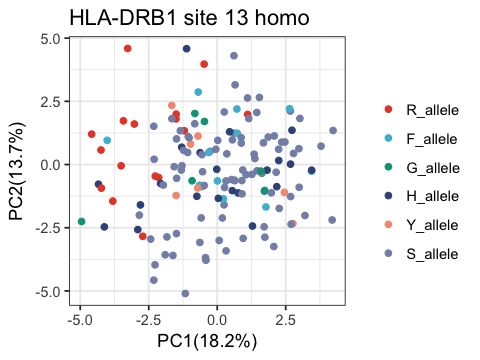

In [145]:
df <- Z[,c("Sample","PC1","PC2")]
df <- merge(G,df,by="Sample")
head(df,n=2)

    #df$color <- ifelse( df$Sample %in% target_samples, "1_homo", "2_others")

df$allele <- factor(df$allele,levels=c(
    'R_allele','F_allele','G_allele','H_allele','Y_allele','S_allele'
))

options(repr.plot.width=4, repr.plot.height=3)

df %>% ggplot(aes(x=PC1, y=PC2, color=allele)) +
    geom_point() +
    theme_bw() +
    scale_color_npg(name="") +
    labs(title="HLA-DRB1 site 13 homo",x="PC1(18.2%)",y="PC2(13.7%)") -> p
plot(p)

## 7, genotype vs frequency plot

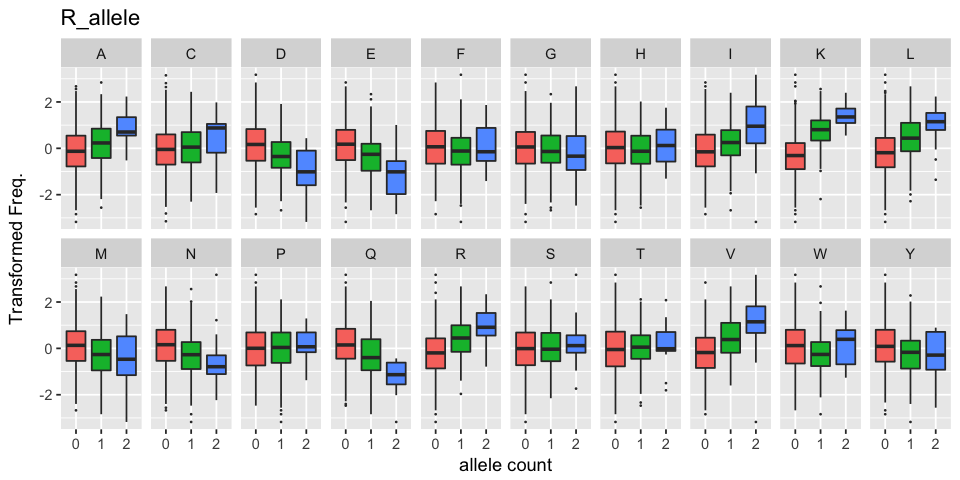

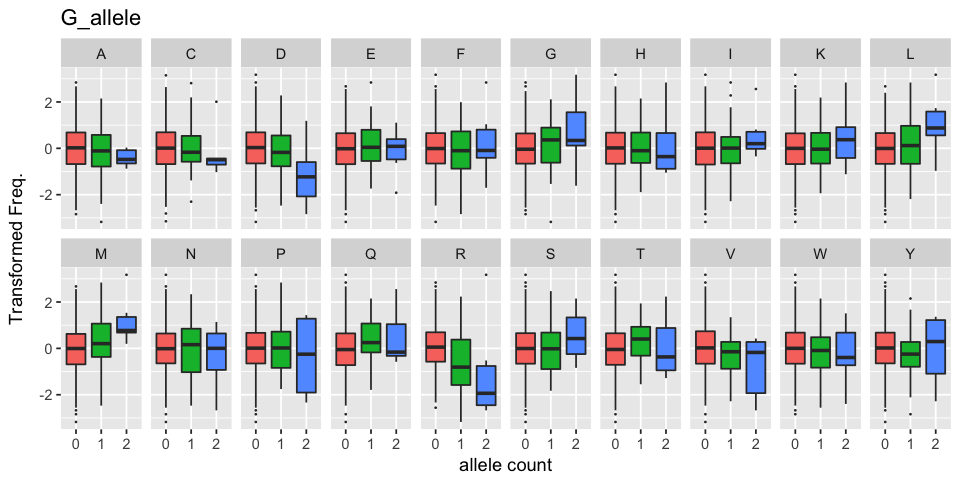

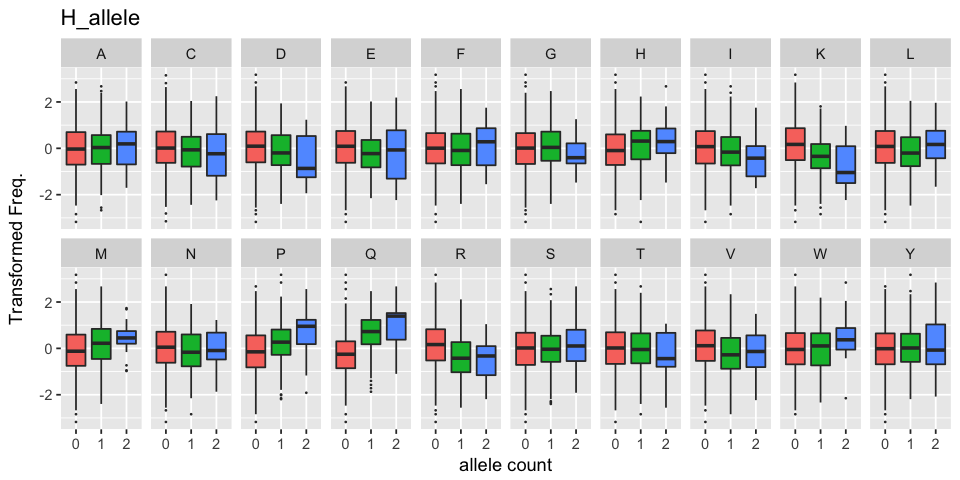

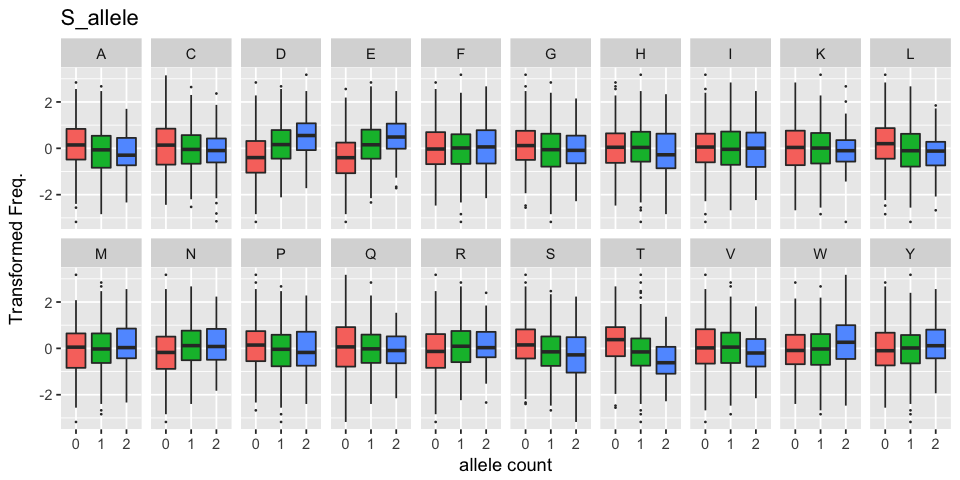

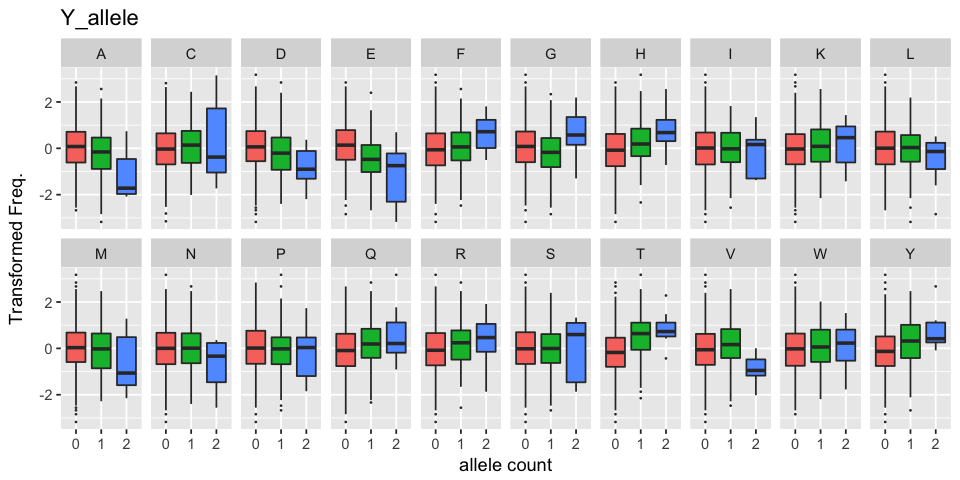

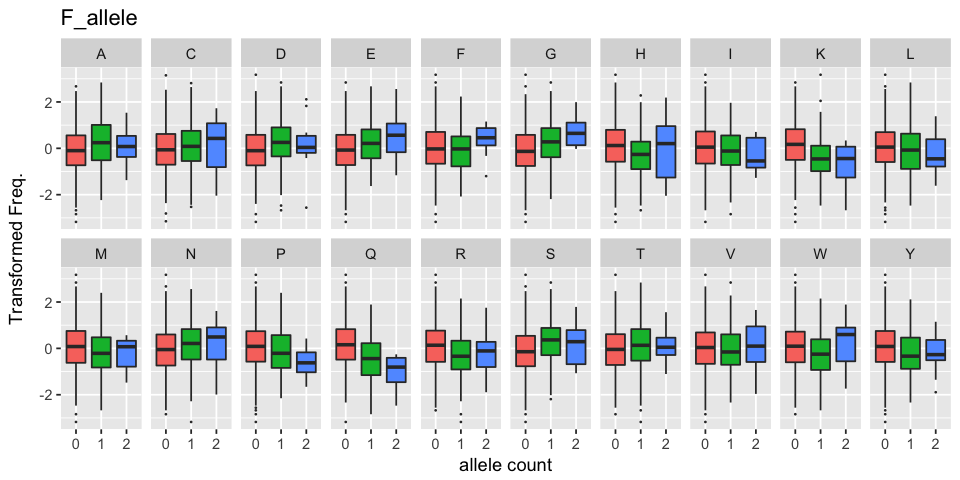

In [159]:
options(repr.plot.width=8, repr.plot.height=4)

all_allele <- c('R_allele','G_allele','H_allele','S_allele','Y_allele',
                'F_allele'
               )

for(i in 1:6){
    allele <- all_allele[i]
    d1 <- pall
    d2 <- gdata[,c("Sample",allele)]
    df <- merge(d1,d2,by="Sample")
    colnames(df)[4] <- "dose"
    df$dose <- as.character(df$dose)
    #head(df,n=2)
    
    df %>% ggplot(aes(x=dose,y=normrate,fill=dose)) +
        facet_wrap(~AA,ncol=10)+ #
        labs(y="Transformed Freq.")+
        geom_boxplot(outlier.size = 0.1) +
        theme(legend.position = "none") +
        labs(title=allele,x="allele count") -> p
    
    plot(p)
}


## cross validation

In [83]:
head(pdata,n=2)
head(gdata,n=2)
head(cdata,n=2)

Sample,AA,rate
HIP00110,A,0.066906200
HIP00110,C,0.000359324


,Sample,F,G,H,R,S,Y
HIP00110,HIP00110,0,0,0,2,0,0
HIP00169,HIP00169,0,0,0,2,0,0


,Sample,PC1,PC2,PC3,order
HIP00110,HIP00110,-0.3715639,0.1614687,0.9765430,4
HIP00169,HIP00169,-0.8574693,1.4323182,-0.9377073,4


In [94]:
#set CV group
nrow(cdata)
order <- c(rep("1",126),rep("2",126),rep("3",126),rep("4",125),rep("5",125))
order <- sample(order)
cdata$order <- order #order: CV group

[1] 628

In [95]:
#estimate performance in CV
allaa <- unique(pdata$AA)
res <- data.frame()
for(CV in 1:5){
    #discovery data
    cdata_discovery <- subset(cdata, order!=CV)
    d1 <- merge(pdata,gdata,by="Sample")
    x <- d1$rate
    d1$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
    discovery <- merge(d1,cdata_discovery,by="Sample")
    
    #validation data
    cdata_validation <- subset(cdata, order==CV)
    d1 <- merge(pdata,gdata,by="Sample")
    x <- d1$rate
    d1$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
    validation <- merge(d1,cdata_validation,by="Sample")
    
    for(aa in allaa){
        discovery_mini <- subset(discovery,AA==aa)
        validation_mini <- subset(validation,AA==aa)
        
        mod1 <- lm( rate ~ F + G + H + R + Y + PC1 + PC2 + PC3, data = discovery_mini)
        beta <- summary(mod1)$coefficient[c("F","G","H","R","Y"),"Estimate"]
        
        pred <- as.matrix(validation_mini[,c("F","G","H","R","Y")]) %*% beta
        real <- validation_mini$rate
        cor.pearson <- cor(pred,real,method="pearson")
        cor.spearman <- cor(pred,real,method="spearman")
        
        dump <- data.frame(CV,AA=aa, cor.pearson, cor.spearman )
        res <- rbind(res,dump)
    }
}

In [96]:
res <- res[order(res$cor.pearson,decreasing = T),]
nrow(res)
head(res,n=2)

[1] 100

,CV,AA,cor.pearson,cor.spearman
49,3,K,0.6571422,0.6334994
54,3,Q,0.6222500,0.6118380


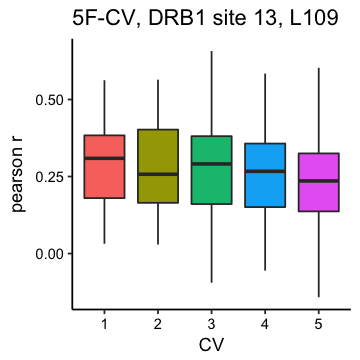

In [97]:
#plot r 
options(repr.plot.width=3, repr.plot.height=3)

df <- res
df$CV <- factor(df$CV)

df %>% ggplot(aes(x=CV,y=cor.pearson,fill=CV)) +
    labs(y="pearson r",title="5F-CV, DRB1 site 13, L109")+
    geom_boxplot(outlier.size = 0.1) +
    theme_bw() +
    theme(legend.position = "none")  +
    theme( axis.line = element_line(colour = "black"), axis.text=element_text(colour="black") ) +
    theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) +
    theme( panel.border = element_blank(), panel.background = element_blank() ) 


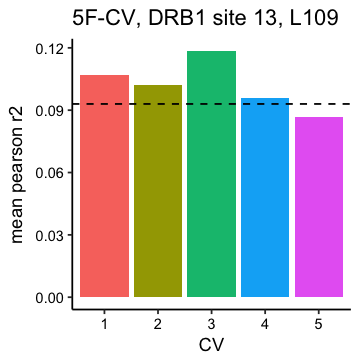

In [137]:
#plot r2

#df$r2 <- df$cor.pearson^2
#df2 <-ddply(df[,c("CV","r2")], c("CV"), colwise(mean))

df2 %>% ggplot(aes(x=CV,y=r2,fill=CV)) +
    labs(y="mean pearson r2",title="5F-CV, DRB1 site 13, L109")+
    geom_bar(stat="identity") +
    theme_bw() +
    geom_hline(yintercept = 0.093, linetype="dashed") +
    theme(legend.position = "none")  +
    theme( axis.line = element_line(colour = "black"), axis.text=element_text(colour="black") ) +
    theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) +
    theme( panel.border = element_blank(), panel.background = element_blank() ) 

In [135]:
df2

CV,r2
1,0.10697008
2,0.10203987
3,0.11844011
4,0.09609702
5,0.08650730


In [99]:
mean(res$cor.pearson)
mean(res$cor.pearson^2)

[1] 0.2714378

[1] 0.1020109

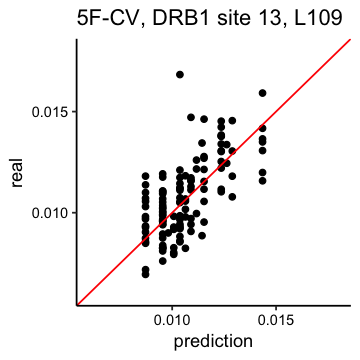

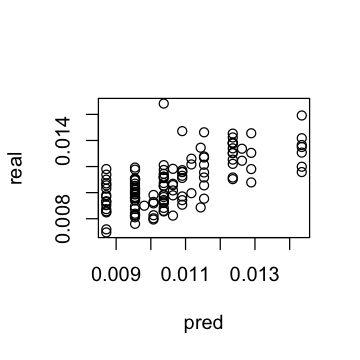

In [132]:
#plot example
#estimate performance in CV
CV = 3
aa = "K"

#discovery data
cdata_discovery <- subset(cdata, order!=CV)
d1 <- merge(pdata,gdata,by="Sample")
x <- d1$rate
d1$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
discovery <- merge(d1,cdata_discovery,by="Sample")

#validation data
cdata_validation <- subset(cdata, order==CV)
d1 <- merge(pdata,gdata,by="Sample")
x <- d1$rate
d1$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
validation <- merge(d1,cdata_validation,by="Sample")

discovery_mini <- subset(discovery,AA==aa)
validation_mini <- subset(validation,AA==aa)

mod1 <- lm( rate ~ F + G + H + R + Y + PC1 + PC2 + PC3, data = discovery_mini)
beta <- summary(mod1)$coefficient[c("F","G","H","R","Y"),"Estimate"]
int <- summary(mod1)$coefficient[1,"Estimate"]

pred <- as.matrix(validation_mini[,c("F","G","H","R","Y")]) %*% beta + int
real <- validation_mini$rate

df <- data.frame(pred,real)
df %>% ggplot(aes(x=pred,y=real)) +
    geom_point() +
    #geom_smooth(method="lm") +
    geom_abline( slope  =1, intercept = 0, color="red") +
    scale_x_continuous(limits=c(0.006,0.018)) +
    scale_y_continuous(limits=c(0.006,0.018)) +
    labs(x="prediction",y="real",title="5F-CV, DRB1 site 13, L109")+
    theme_bw() +
    theme(legend.position = "none")  +
    theme( axis.line = element_line(colour = "black"), axis.text=element_text(colour="black") ) +
    theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) +
    theme( panel.border = element_blank(), panel.background = element_blank() ) 

plot(df)

In [114]:
summary(df)

      pred                 real         
 Min.   :-0.0016573   Min.   :0.006949  
 1st Qu.:-0.0008287   1st Qu.:0.009406  
 Median : 0.0000000   Median :0.010560  
 Mean   : 0.0002692   Mean   :0.010783  
 3rd Qu.: 0.0011599   3rd Qu.:0.011826  
 Max.   : 0.0039771   Max.   :0.016830  